# Analysis of different ways to estimate correlation dimension

Generates figures S2, S3 and S14 for Supplementary Materials.

In [6]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from Bio import SeqIO
import itertools
import seaborn as sns
import copy
import sys
import math
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.special import comb
# add the path to the sequence_space_lib.py and  __init__.py files to your path 
sys.path.append("../src/seq_space_lib/")
import sequence_space_lib as seqsp 

sys.path.append("../src/simulate_prot_evol_lib/")
import simulate_prot_evol_lib as simevol

allsumpath='../data/'


# Test different correlation dimension regression window sizes on random fit sequences

### Simulate data

In [ ]:
usages=range(2,21)
lens=[100,200,300,400,500]
u220l100500_ws4=[]
for lens in tqdm(lens):
    randseq=simevol.generate_nt_seq(lens*3, 1, seqfrom='random', select_from='aa')
    randseqaa=str(Seq(randseq).translate())
    for u in usages:
        for i in range(5):
            lib1000aa=generate_aa_library(randseqaa, list(range(lens)), nseq=1000, usage=u)
            dists=simevol.get_distance_array(lib1000aa)
            dim, dimr2, dimci=seqsp.max_k(dists, win_size_perc=0.4, numbins=20, plot = False,  reg_range_from_data=True, flat=True, ci_r2_out_flat=True)
            dim3, dimr23, dimci3=seqsp.max_k(dists, win_size_perc=0.3, numbins=20, plot = False,  reg_range_from_data=True, flat=True, ci_r2_out_flat=True)
            u220l100500_ws4.append([dim, dimr2, dimci, dim3, dimr23, dimci3, np.max(dists), np.mean(dists), u, lens])
dfu220l100500_ws4=pd.DataFrame(u220l100500_ws4, columns=['dim_0.4', 'dim_r^2_0.4', 'dim_ci_0.4', 'dim_0.3', 'dim_r^2_0.3', 'dim_ci_0.3', 'max_dist', 'mean_dist', 'usage', 'length'])

100%|██████████| 5/5 [2:48:58<00:00, 2027.73s/it]  


In [ ]:
tomelt=dfu220l100500_ws4.reset_index()
tomelt

,index,dim_0.4,dim_r^2_0.4,dim_ci_0.4,dim_0.3,dim_r^2_0.3,dim_ci_0.3,max_dist,mean_dist,usage,length
0,0,20.932928,0.995257,1.146331,22.227285,0.998960,0.764301,0.720,0.500027,2,100
1,1,20.370171,0.994691,1.180592,21.264275,0.995064,1.596366,0.720,0.499998,2,100
2,2,21.235645,0.991949,1.517715,22.675794,0.994032,1.872829,0.730,0.499933,2,100
3,3,20.570886,0.993777,1.291336,21.859550,0.994960,1.658299,0.750,0.499982,2,100
4,4,21.555921,0.987302,1.939279,23.713373,0.994693,1.846280,0.740,0.500010,2,100
...,...,...,...,...,...,...,...,...,...,...,...
470,470,251.791900,0.987735,22.258632,278.647484,0.993064,24.823163,0.986,0.949997,20,500
471,471,257.648397,0.991734,18.659783,279.512448,0.995749,19.467744,0.988,0.949991,20,500
472,472,250.770807,0.989733,20.262213,275.430084,0.995094,20.615243,0.990,0.949996,20,500
473,473,257.723547,0.972653,34.282321,292.644117,0.974488,50.472358,0.986,0.950017,20,500


In [ ]:
df = tomelt.copy()

long = (
    pd.wide_to_long(
        df,
        stubnames=["dim", "dim_r^2", "dim_ci"],
        i="index",
        j="win_size",
        sep="_",
        suffix=r"[0-9.]+"
    )
    .reset_index()
)
long=long[['win_size', 'length', 'max_dist', 'mean_dist', 'usage', 'dim',
       'dim_r^2', 'dim_ci']]
long

,win_size,length,max_dist,mean_dist,usage,dim,dim_r^2,dim_ci
0,0.4,100,0.720,0.500027,2,20.932928,0.995257,1.146331
1,0.4,100,0.720,0.499998,2,20.370171,0.994691,1.180592
2,0.4,100,0.730,0.499933,2,21.235645,0.991949,1.517715
3,0.4,100,0.750,0.499982,2,20.570886,0.993777,1.291336
4,0.4,100,0.740,0.500010,2,21.555921,0.987302,1.939279
...,...,...,...,...,...,...,...,...
945,0.3,500,0.986,0.949997,20,278.647484,0.993064,24.823163
946,0.3,500,0.988,0.949991,20,279.512448,0.995749,19.467744
947,0.3,500,0.990,0.949996,20,275.430084,0.995094,20.615243
948,0.3,500,0.986,0.950017,20,292.644117,0.974488,50.472358


In [ ]:
#calculate effective topological dimension
long['n_seq_from_dim_log10']=  long['dim']*np.log10(long['length'])
long['n_seq_from_dim_log20'] = long['n_seq_from_dim_log10'] / np.log10(20)
long['n_seq_from_dim_log_alpha'] = long['n_seq_from_dim_log10'] / np.log10(long['usage'])
long['n_seq_from_dim_log10_ci']=  long['dim_ci']*np.log10(long['length'])
long['n_seq_from_dim_log20_ci'] = long['n_seq_from_dim_log10_ci'] / np.log10(20)
long['n_seq_from_dim_log_alpha_ci'] = long['n_seq_from_dim_log10_ci'] / np.log10(long['usage'])
long

,win_size,length,max_dist,mean_dist,usage,dim,dim_r^2,dim_ci,n_seq_from_dim_log10,n_seq_from_dim_log20,n_seq_from_dim_log_alpha,n_seq_from_dim_log10_ci,n_seq_from_dim_log20_ci,n_seq_from_dim_log_alpha_ci
0,0.4,100,0.720,0.500027,2,20.932928,0.995257,1.146331,41.865856,32.179009,139.075364,2.292663,1.762191,7.616061
1,0.4,100,0.720,0.499998,2,20.370171,0.994691,1.180592,40.740341,31.313914,135.336485,2.361184,1.814857,7.843683
2,0.4,100,0.730,0.499933,2,21.235645,0.991949,1.517715,42.471290,32.644359,141.086571,3.035429,2.333097,10.083478
3,0.4,100,0.750,0.499982,2,20.570886,0.993777,1.291336,41.141773,31.622463,136.670012,2.582672,1.985098,8.579450
4,0.4,100,0.740,0.500010,2,21.555921,0.987302,1.939279,43.111841,33.136701,143.214437,3.878557,2.981144,12.884288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,0.3,500,0.986,0.949997,20,278.647484,0.993064,24.823163,752.061201,578.050624,578.050624,66.996974,51.495333,51.495333
946,0.3,500,0.988,0.949991,20,279.512448,0.995749,19.467744,754.395712,579.844980,579.844980,52.542857,40.385584,40.385584
947,0.3,500,0.990,0.949996,20,275.430084,0.995094,20.615243,743.377536,571.376170,571.376170,55.639923,42.766057,42.766057
948,0.3,500,0.986,0.950017,20,292.644117,0.974488,50.472358,789.837694,607.086460,607.086460,136.223381,104.704258,104.704258


In [33]:
#load data for window size=0.5 (generated in compare_dim_to_random_seq.ipynb)
dfu220l50500=pd.read_csv('../data/small_simulations/random_seq_dim_length50-500_usage2-20_map.csv')

In [ ]:
ws5=[]
for ind, i in dfu220l50500.iterrows():
    if i['length']%100==0:
        ws5.append(ind)
long5=dfu220l50500.loc[ws5]
long5['win_size']=[0.5]*len(ws5)
wslen=pd.concat([long, long5], ignore_index=True)
wslen

,win_size,length,max_dist,mean_dist,usage,dim,dim_r^2,dim_ci,n_seq_from_dim_log10,n_seq_from_dim_log20,n_seq_from_dim_log_alpha,n_seq_from_dim_log10_ci,n_seq_from_dim_log20_ci,n_seq_from_dim_log_alpha_ci
0,0.4,100,0.720,0.500027,2,20.932928,0.995257,1.146331,41.865856,32.179009,139.075364,2.292663,1.762191,7.616061
1,0.4,100,0.720,0.499998,2,20.370171,0.994691,1.180592,40.740341,31.313914,135.336485,2.361184,1.814857,7.843683
2,0.4,100,0.730,0.499933,2,21.235645,0.991949,1.517715,42.471290,32.644359,141.086571,3.035429,2.333097,10.083478
3,0.4,100,0.750,0.499982,2,20.570886,0.993777,1.291336,41.141773,31.622463,136.670012,2.582672,1.985098,8.579450
4,0.4,100,0.740,0.500010,2,21.555921,0.987302,1.939279,43.111841,33.136701,143.214437,3.878557,2.981144,12.884288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,0.5,500,0.992,0.950004,20,239.167030,0.969085,28.084699,645.504640,496.148930,496.148930,75.799760,58.261347,58.261347
1421,0.5,500,0.986,0.949982,20,224.613506,0.979604,21.308278,606.225115,465.957831,465.957831,57.510403,44.203749,44.203749
1422,0.5,500,0.992,0.950002,20,234.643393,0.976567,23.896589,633.295478,486.764702,486.764702,64.496177,49.573167,49.573167
1423,0.5,500,0.990,0.949994,20,211.350700,0.984072,17.678280,570.429200,438.444311,438.444311,47.713148,36.673365,36.673365


In [ ]:
wslen.to_csv('../data/small_simulations/random_seq_from_aa_dim_winsize03-05_length100-500_usage2-20_map.csv', index=False)

### Analyse

In [32]:
wslen=pd.read_csv('../data/small_simulations/random_seq_from_aa_dim_winsize03-05_length100-500_usage2-20_map.csv')

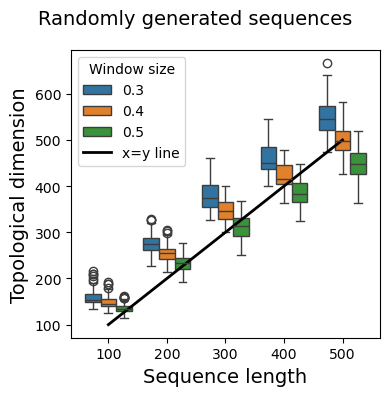

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

palette = ['tab:blue', 'tab:orange', 'tab:green']

g=sns.boxplot(
    data=wslen,
    x='length', y='n_seq_from_dim_log_alpha',
    hue='win_size', palette=palette, ax=ax
)

# get category order (x positions)
x_order = sorted(wslen['length'].unique())
x_pos = np.arange(len(x_order))  # positions 0,1,2,...


#for color, (ws, sub) in zip(palette, wslen.groupby('win_size')):
#    # map each categorical x to its numeric position
#    xi = [x_pos[x_order.index(l)] for l in sub['length']]
#    slope, intercept, r, p, se = stats.linregress(xi, sub['n_seq_from_dim_log_alpha'])
#    y_pred = intercept + slope * np.array(xi)
#    plt.plot(xi, y_pred, color=color, lw=2, linestyle='--', label='Window size='+str(ws)+'\n'+"y={:.2f}x+{:.2f}".format(slope/100,intercept/100))

plt.plot(g.get_xticks(), list(set(wslen['length'])), color='k', lw=2, alpha=1, label='x=y line')

plt.suptitle('Randomly generated sequences', size=14)
plt.legend(title='Window size')
plt.ylabel('Topological dimension' 
           #+ r"$\log_{U}$(seq. space volume)"
           , size=14)
plt.xlabel('Sequence length', size=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_order)
plt.tight_layout()
plt.show()

# Compare dimension with range from data window size 0.3, 0.4, 0.5

In [8]:
# Load dimensionality estimated using the regression range determined by each distance matrix #load datasets
vdfr=pd.read_csv(allsumpath+'vertebrates_summary.csv')
edfr=pd.read_csv(allsumpath+'enterobacterales_summary.csv')
gdfr=pd.read_csv(allsumpath+'gammaproteobacteria_summary.csv')
sdfr=pd.read_csv(allsumpath+'simulated_summary.csv')

In [9]:
#add range_from_data dimw with win_size 0.3 and 0.4 
l=['eggnog_gamma_kcoefs_mult_ali_max_k_range_from_data_non_log_0.3_20.coefnr',
'eggnog_gamma_kcoefs_mult_ali_max_k_range_from_data_non_log_0.4_20.coefnr',
'entero_kcoefs_mult_ali_max_k_range_from_data_non_log_0.3_20.coefnr',
'entero_kcoefs_mult_ali_max_k_range_from_data_non_log_0.4_20.coefnr',
'kcoefs_mult_ali_max_k_range_from_data_unique_non_log_0.3_20.coefnr',
'kcoefs_mult_ali_max_k_range_from_data_unique_non_log_0.4_20.coefnr',
'simu_kcoefs_mult_ali_max_k_range_from_data_non_log_0.3_20.coefnr',
'simu_kcoefs_mult_ali_max_k_range_from_data_non_log_0.4_20.coefnr']

dfs3=[]
dfs4=[]
for ind, i in enumerate(l):
    df=pd.read_csv(allsumpath+'dim_diff_reg_range/'+i, sep=',')
    coln=['range_start_data_range_','range_end_data_range_','max_k_data_range_','max_k_R^2_data_range_','max_CI_data_range_']
    if ind%2==0:
        ws=0.3
        df.columns=['OG_id']+[i+str(ws) for i in coln]
        dfs3.append(df)
    else:
        ws=0.4
        df.columns=['OG_id']+[i+str(ws) for i in coln]
        dfs4.append(df)

gdfr34=gdfr.merge(dfs3[0].merge(dfs4[0], on='OG_id'), on='OG_id')
edfr34=edfr.merge(dfs3[1].merge(dfs4[1], on='OG_id'), on='OG_id')
vdfr34=vdfr.merge(dfs3[2].merge(dfs4[2], on='OG_id'), on='OG_id')
sdfr34=sdfr.merge(dfs3[3].merge(dfs4[3], on='OG_id'), left_on='SimuID', right_on='OG_id')

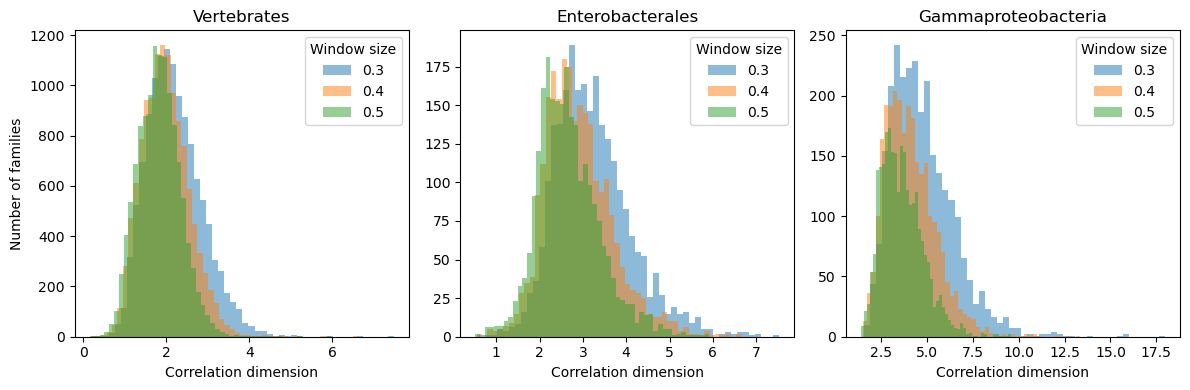

In [10]:
#hist of r^2
fig, ax=plt.subplots(1,3, figsize=(12,4))
names=['Vertebrates', 'Enterobacterales', 'Gammaproteobacteria']
dfr=[vdfr34, edfr34, gdfr34]
for i in range(3):
    ax[i].hist(dfr[i]['max_k_data_range_0.3'],bins=50, label='0.3', alpha=0.5)
    ax[i].hist(dfr[i]['max_k_data_range_0.4'],bins=50, label='0.4', alpha=0.5)
    ax[i].hist(dfr[i]['dim_ur'], label='0.5', bins=50,alpha=0.5)
    ax[i].set_title(names[i])
    if i==0:
        ax[i].set_ylabel('Number of families')
    ax[i].set_xlabel('Correlation dimension')
    ax[i].legend(title='Window size')
plt.tight_layout()

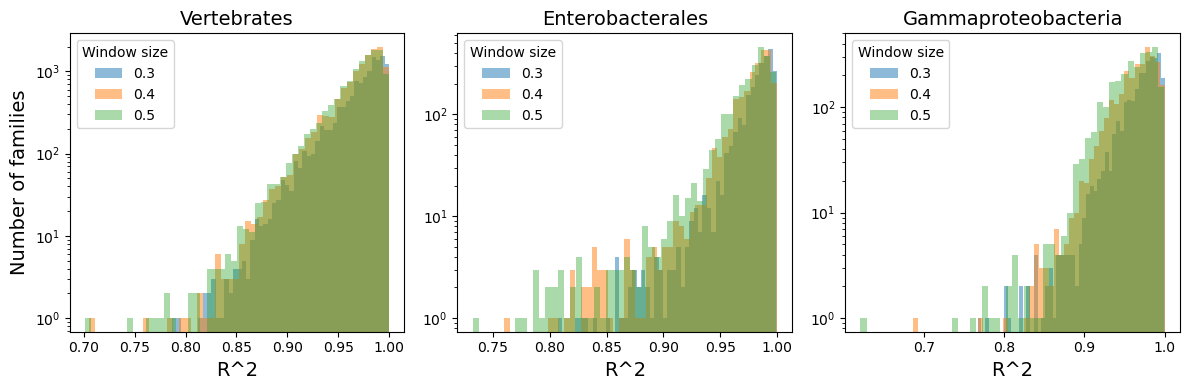

In [ ]:
#hist of r^2 - log scale y axis
palette = ['tab:blue', 'tab:orange', 'tab:green']
fig, ax=plt.subplots(1,3, figsize=(12,4))
names=['Vertebrates', 'Enterobacterales', 'Gammaproteobacteria']
dfr=[vdfr34, edfr34, gdfr34]
for i in range(3):
    ax[i].hist(dfr[i]['max_k_R^2_data_range_0.3'],bins=50,  label='0.3', alpha=0.5, color=palette[0])
    ax[i].hist(dfr[i]['max_k_R^2_data_range_0.4'],bins=50,  label='0.4', alpha=0.5, color=palette[1])
    ax[i].hist(dfr[i]['dim_R^2_ur'], label='0.5', bins=50, alpha=0.4, color=palette[2])
    #ax[i].hist(dfr[i]['max_k_R^2_data_range_0.4'],bins=50,  label='0.4', alpha=0.5)
    #ax[i].hist(dfr[i]['dim_R^2_ur'], label='0.5', bins=50, alpha=0.5)
    ax[i].set_title(names[i], size=14)
    ax[i].set_yscale('log')
    if i==0:
        ax[i].set_ylabel('Number of families', size=14)
    ax[i].set_xlabel('R^2', size=14)
    ax[i].legend(title='Window size')
plt.tight_layout()

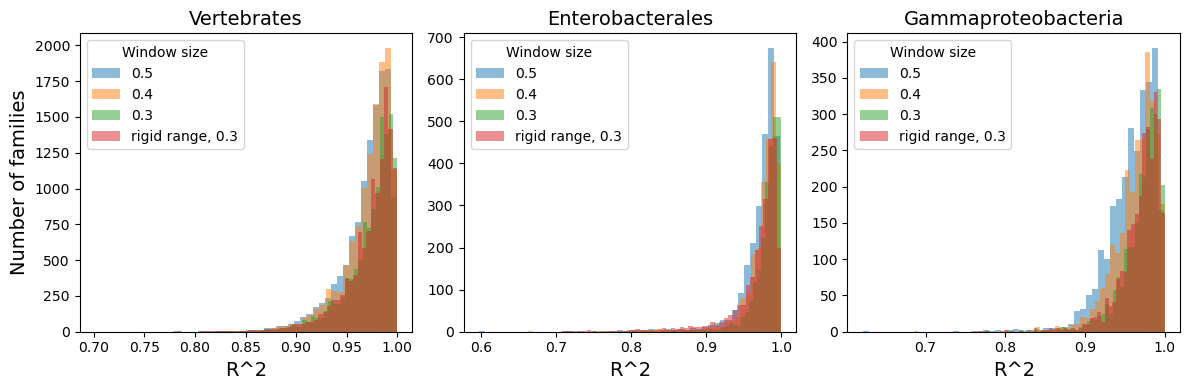

In [ ]:
#hist of r^2
fig, ax=plt.subplots(1,3, figsize=(12,4))
names=['Vertebrates', 'Enterobacterales', 'Gammaproteobacteria']
dfr=[vdfr34, edfr34, gdfr34]
for i in range(3):
    ax[i].hist(dfr[i]['dim_R^2_ur'], label='0.5', bins=50, alpha=0.5)
    ax[i].hist(dfr[i]['max_k_R^2_data_range_0.4'],bins=50,  label='0.4', alpha=0.5)
    ax[i].hist(dfr[i]['max_k_R^2_data_range_0.3'],bins=50,  label='0.3', alpha=0.5)
    ax[i].hist(dfr[i]['dim_R^2_unique'],bins=50,  label='rigid range, 0.3', alpha=0.5)
    #ax[i].hist(dfr[i]['dim_R^2_ur'], label='0.5', bins=50, alpha=0.5)
    ax[i].set_title(names[i], size=14)
    #ax[i].set_yscale('log')
    if i==0:
        ax[i].set_ylabel('Number of families', size=14)
    ax[i].set_xlabel('R^2', size=14)
    ax[i].legend(title='Window size')
plt.tight_layout()

/var/folders/nj/2tn6w9gs7b9fdn95zcp21t440000gp/T/ipykernel_14181/2075856559.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y, s=size, alpha=0.5, cmap=palette)


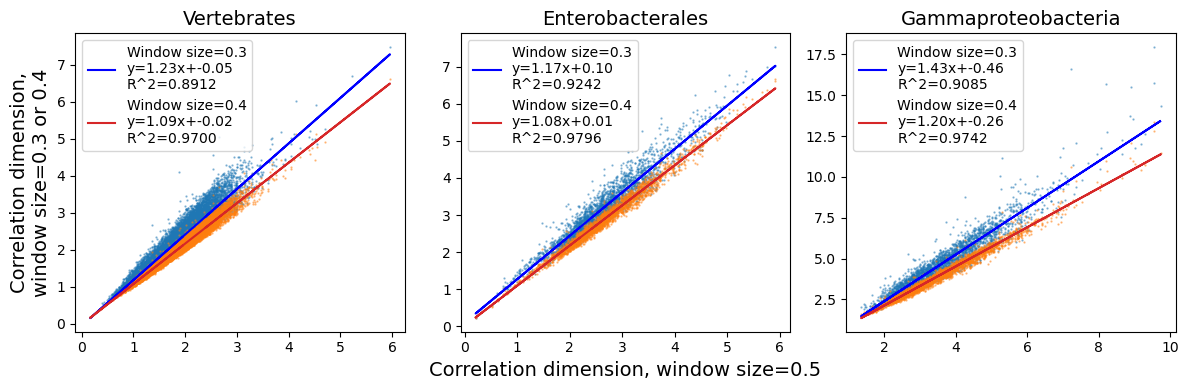

In [ ]:
fig, ax=plt.subplots(1,3, figsize=(12,4))
names=['Vertebrates', 'Enterobacterales', 'Gammaproteobacteria']
dfr=[vdfr34, edfr34, gdfr34]
for i in range(3):
    seqsp.plot_density(dfr[i], '', 'dim_ur', 'max_k_data_range_0.3', dropna=True, ax=ax[i], regcolor='blue',  density=False, legend='Window size=0.3\n')
    seqsp.plot_density(dfr[i], '', 'dim_ur', 'max_k_data_range_0.4', dropna=True, ax=ax[i], regcolor='tab:red', density=False, legend='Window size=0.4\n')
    ax[i].set_title(names[i], size=14)
    if i!=0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('Correlation dimension,\nwindow size=0.3 or 0.4', size=14)
    if i!=1:
        ax[i].set_xlabel('')
    else:
        ax[i].set_xlabel('Correlation dimension, window size=0.5', size=14)
plt.tight_layout()


In [ ]:
#reformat simulated families table
tomelt=sdfr34.reset_index().copy()

long = (
    pd.wide_to_long(
        tomelt,
        stubnames=["max_k_data_range", "max_k_R^2_data_range", 'max_CI_data_range'],
        i="index",
        j="win_size",
        sep="_",
        suffix=r"[0-9.]+"
    )
    .reset_index()
)

long

,index,win_size,OG_id_x,OG_id_y,SimuID,ali_len,branch_length_distr,dim_CI_unique,dim_CI_ur,dim_R^2_unique,dim_R^2_ur,dim_orig,dim_range_end_unique,dim_range_end_ur,dim_range_start_unique,dim_range_start_ur,dim_unique,dim_ur,dn_mean,dn_median,dn_var,dnds_by_median_len,dnds_from_usage,dnds_from_usage_by_median_len,dnds_from_usage_cons,dnds_mean,dnds_mean_tree,dnds_median,dnds_median_tree,dnds_var,dnds_var_tree,ds_mean,ds_median,ds_var,essential_dim0,essential_dim1,filt_length,frac_NA,frac_SE_high,frac_dS<0.1,frac_dS>0.8,frac_var_sites,fraction_allowed_subs,gamma,integral_b0,integral_b1,max_ld,mean_alphabet_size,mean_ld,mean_ld_orig,median_alphabet_size,median_ld,mode,nodes,nonsyn_subs_count,norm_integral_b0,norm_integral_b1,num_invar_sites,num_var_sites,orig_length,range_end_data_range_0.3,range_end_data_range_0.4,range_start_data_range_0.3,range_start_data_range_0.4,replicate,run,suffix,syn_subs_count,total_treelength,tree_len_scale,var_ld,max_k_data_range,max_k_R^2_data_range,max_CI_data_range
0,0,0.3,ali_tree_0.05_exp_0_continuousF.longleaves.run...,SimuOG1731,SimuOG1731,300,exp,0.767,0.508,0.992,0.989,7.78466,0.65,0.90,0.35,0.40,7.785,7.304,0.1645,0.1693,0.0032,96.741,0.266316,79.894737,0.722857,0.3066,0.32424,0.3022,0.32247,0.0036,0.00059,0.5476,0.5778,0.0322,1,1,774.0,0.0,0.0000,0.0001,0.9827,0.926667,0.390,0.0,72.89010,0.06002,0.74333,6.060,0.577528,0.57753,6.0,0.59000,tree,leaves,20506,111.7470,0.093296,22,278.0,44850.0,0.80,0.85,0.50,0.45,0,longleaves,continuousF.longleaves.run1,17680,38186,0.05,0.005181,8.562,0.998,0.433
1,1,0.3,ali_tree_0.05_exp_1_continuousF.longleaves.run...,SimuOG4491,SimuOG4491,300,exp,0.657,0.682,0.995,0.982,8.75515,0.85,1.00,0.55,0.50,8.755,7.561,0.3278,0.3261,0.0137,189.456,0.641579,192.473684,1.741429,0.5860,0.63154,0.5769,0.63152,0.0131,0.00243,0.5638,0.5983,0.0298,298,5,1967.0,0.0,0.0000,0.0003,0.9558,1.000000,0.656,1.0,97.43330,0.08002,0.90667,13.190,0.756496,0.75650,13.0,0.77667,tree,leaves,27275,117.1260,0.097191,0,300.0,44850.0,0.90,0.95,0.60,0.55,0,longleaves,continuousF.longleaves.run1,12613,39888,0.05,0.007672,9.267,0.998,0.459
2,2,0.3,ali_tree_0.05_exp_10_continuousF.longleaves.ru...,SimuOG3501,SimuOG3501,300,exp,0.396,0.295,0.996,0.994,6.14765,0.65,0.85,0.35,0.35,6.148,5.687,0.1004,0.0988,0.0013,67.209,0.548789,164.636842,1.489571,0.1941,0.22404,0.1894,0.22403,0.0019,0.00026,0.5297,0.5470,0.0323,20,2,365.0,0.0,0.0000,0.0000,0.9918,1.000000,0.264,10.0,62.30000,0.05333,0.81000,11.427,0.579830,0.57983,11.0,0.59000,tree,leaves,17082,89.2714,0.077665,0,300.0,44850.0,0.75,0.80,0.45,0.40,0,longleaves,continuousF.longleaves.run1,22432,39514,0.05,0.008871,6.447,0.999,0.195
3,3,0.3,ali_tree_0.05_exp_100_continuousF.longleaves.r...,SimuOG2610,SimuOG2610,300,exp,0.518,0.441,0.996,0.990,7.38852,0.80,0.90,0.50,0.40,7.389,6.539,0.1784,0.1772,0.0050,97.860,0.713316,213.994737,1.936143,0.3239,0.32704,0.3129,0.32620,0.0048,0.00055,0.5514,0.5902,0.0324,2,4,718.0,0.0,0.0000,0.0000,0.9839,1.000000,0.375,100.0,78.23340,0.04000,0.92333,14.553,0.710641,0.71064,14.5,0.72667,tree,leaves,19843,98.1776,0.050847,0,300.0,44850.0,0.80,0.85,0.50,0.45,0,longleaves,continuousF.longleaves.run1,17306,37149,0.05,0.009713,7.632,0.998,0.333
4,4,0.3,ali_tree_0.05_exp_0_continuousF.longleaves.run...,SimuOG1695,SimuOG1695,300,exp,0.654,0.413,0.992,0.992,6.83267,0.55,0.85,0.25,0.35,6.833,7.036,0.1072,0.1098,0.0012,68.268,0.160368,48.110526,0.435286,0.1945,0.22764,0.1890,0.22756,0.0018,0.00032,0.5641,0.6097,0.0314,7,1,437.0,0.0,0.0000,0.0000,0.9903,0.870000,0.285,0.0,60.45330,0.20330,0.62000,4.047,0.466743,0.46674,4.0,0.47667,tree,leaves,16755,111.4760,0.381190,39,261.0,44850.0,0.80,0.80,0.50,0.40,1,longleaves,continuousF.longleaves.run1,21068,37823,0.05,0.003706,8.054,0.998,0.393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

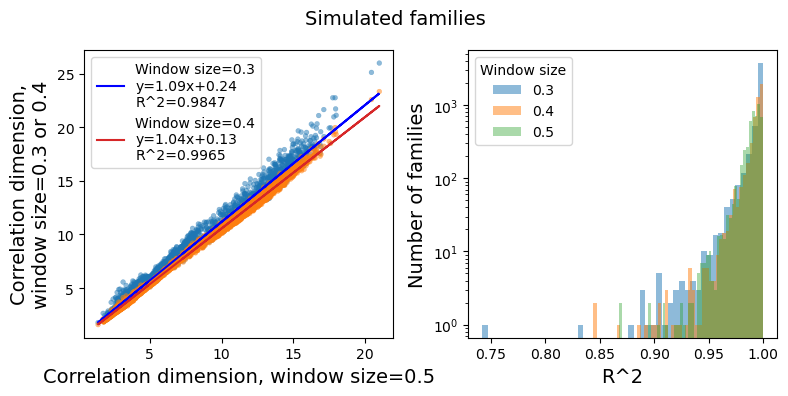

In [ ]:
fig, ax=plt.subplots(1,2, figsize=(8,4))
palette = ['tab:blue', 'tab:orange', 'tab:green']
sns.scatterplot(long, y='max_k_data_range', x='dim_ur',hue='win_size', s=12, alpha=0.5, 
                palette=['tab:blue', 'tab:orange'], edgecolor=None, ax=ax[0], legend=False) 
m, b, r_value, p_value, std_err = stats.linregress(sdfr34['dim_ur'], sdfr34['max_k_data_range_0.3'])
ax[0].plot(sdfr34['dim_ur'], m*sdfr34['dim_ur'] + b,label='Window size=0.3\n'+"y={:.2f}x+{:.2f}\nR^2={:.4f}".format(m, b,r_value**2), c='blue')
m, b, r_value, p_value, std_err = stats.linregress(sdfr34['dim_ur'], sdfr34['max_k_data_range_0.4'])
ax[0].plot(sdfr34['dim_ur'], m*sdfr34['dim_ur'] + b,label='Window size=0.4\n'+"y={:.2f}x+{:.2f}\nR^2={:.4f}".format(m, b,r_value**2), c='tab:red')
ax[0].legend()

ax[1].hist(sdfr34['max_k_R^2_data_range_0.3'], label='0.3', bins=50, alpha=0.5, color=palette[0])
ax[1].hist(sdfr34['max_k_R^2_data_range_0.4'], label='0.4', bins=50, alpha=0.5, color=palette[1])
ax[1].hist(sdfr34['dim_R^2_ur'], label='0.5', bins=50, alpha=0.4, color=palette[-1])
ax[1].set_yscale('log')
ax[1].legend(title='Window size')

ax[0].set_ylabel('Correlation dimension,\nwindow size=0.3 or 0.4', size=14)
ax[0].set_xlabel('Correlation dimension, window size=0.5', size=14)
ax[1].set_xlabel('R^2', size=14)
ax[1].set_ylabel('Number of families', size=14)
plt.suptitle('Simulated families', size=14)
plt.tight_layout()

In [14]:
for i in [vdfr34, edfr34, gdfr34]:
    seqsp.add_topol_dim_cols(i, dimcol='max_k_data_range_0.3', dimCIcol='max_CI_data_range_0.3', prefix='ws0.3') # r = median seq len * max dist in the matrix 
    seqsp.add_topol_dim_cols(i, dimcol='max_k_data_range_0.4', dimCIcol='max_CI_data_range_0.4', prefix='ws0.4') # r = median seq len * max dist in the matrix 
    #add fraction of explored space
    seqsp.fraction_of_explored_space(i, prefix='ws0.3')
    seqsp.fraction_of_explored_space(i, prefix='ws0.4')

#same for simulated 
seqsp.add_topol_dim_cols(sdfr34, seqlen_col='ali_len', dimcol='max_k_data_range_0.3', dimCIcol='max_CI_data_range_0.3', prefix='ws0.3', alpha_col='median_alphabet_size') # r = median seq len * max dist in the matrix 
seqsp.add_topol_dim_cols(sdfr34, seqlen_col='ali_len', dimcol='max_k_data_range_0.4', dimCIcol='max_CI_data_range_0.4', prefix='ws0.4', alpha_col='median_alphabet_size') # r = median seq len * max dist in the matrix 

#add fraction of explored space
seqsp.fraction_of_explored_space(sdfr34, prefix='ws0.3')
seqsp.fraction_of_explored_space(sdfr34, prefix='ws0.4')


,OG_id_x,SimuID,ali_len,num_invar_sites,num_var_sites,frac_var_sites,mean_alphabet_size,median_alphabet_size,max_ld,mean_ld,...,ws0.4log10_nseq_ci,ws0.4log20_nseq_ci,ws0.3n_seq_diff_usage_log20,ws0.3n_seq_diff_dnds_log20,ws0.3n_seq_diff_usage_log10,ws0.3n_seq_diff_dnds_log10,ws0.4n_seq_diff_usage_log20,ws0.4n_seq_diff_dnds_log20,ws0.4n_seq_diff_usage_log10,ws0.4n_seq_diff_dnds_log10
0,ali_tree_0.05_exp_0_continuousF.longleaves.run...,SimuOG1731,300,22,278.0,0.926667,6.060,6.0,0.74333,0.577528,...,1.115444,0.857354,157.309620,159.691557,204.664534,207.763506,158.416058,160.797996,206.104043,209.203016
1,ali_tree_0.05_exp_1_continuousF.longleaves.run...,SimuOG4491,300,0,300.0,1.000000,13.190,13.0,0.90667,0.756496,...,1.475350,1.133986,238.088171,227.245336,309.759852,295.652998,239.676874,228.834039,311.826803,297.719949
2,ali_tree_0.05_exp_10_continuousF.longleaves.ru...,SimuOG3501,300,0,300.0,1.000000,11.427,11.0,0.81000,0.579830,...,0.689440,0.529919,226.103351,114.150617,294.167242,148.513376,226.853305,114.900571,295.142955,149.489089
3,ali_tree_0.05_exp_100_continuousF.longleaves.r...,SimuOG2610,300,0,300.0,1.000000,14.553,14.5,0.92333,0.710641,...,0.979434,0.752814,252.467706,166.819251,328.468059,217.036849,253.460820,167.812364,329.760130,218.328920
4,ali_tree_0.05_exp_0_continuousF.longleaves.run...,SimuOG1695,300,39,261.0,0.870000,4.047,4.0,0.62000,0.466743,...,0.857876,0.659382,115.012753,112.134104,149.635041,145.889833,115.879718,113.001069,150.762989,147.017781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4840,ali_tree_2.3_exp_100_continuousF.shortleaves.r...,SimuOG10353,300,0,300.0,1.000000,5.327,5.0,0.58000,0.330774,...,0.918625,0.706075,148.299461,20.306812,192.942047,26.419771,149.182916,21.190267,194.091448,27.569173
4841,ali_tree_2.3_exp_0_continuousF.shortleaves.run...,SimuOG9531,300,39,261.0,0.870000,3.767,3.5,0.60333,0.434292,...,0.855659,0.657678,106.484307,124.649167,138.539277,162.172305,107.313780,125.478640,139.618446,163.251474
4842,ali_tree_2.3_exp_1_continuousF.shortleaves.run...,SimuOG12237,300,22,278.0,0.926667,3.873,4.0,0.60667,0.407417,...,0.311890,0.239726,123.600552,104.071296,160.808026,135.399878,123.850701,104.321445,161.133477,135.725329
4843,ali_tree_2.3_exp_10_continuousF.shortleaves.ru...,SimuOG11289,300,0,300.0,1.000000,5.787,6.0,0.63000,0.405907,...,0.248134,0.190721,168.464553,69.409479,219.177437,90.303815,168.721765,69.666691,219.512077,90.638454


In [41]:
from matplotlib.ticker import FuncFormatter

def loglike_formatter(x, pos):
    """
    x is the tick value (your integer),
    pos is the tick index (ignored here).
    Adjust the exponent mapping to what you actually want.
    """
    exp = int(round(x))          # if x itself is the exponent
    # exp = int(round(x / 100))  # if 0,100,200,... should become 0,1,2,...
    return rf"$10^{{-{exp}}}$"


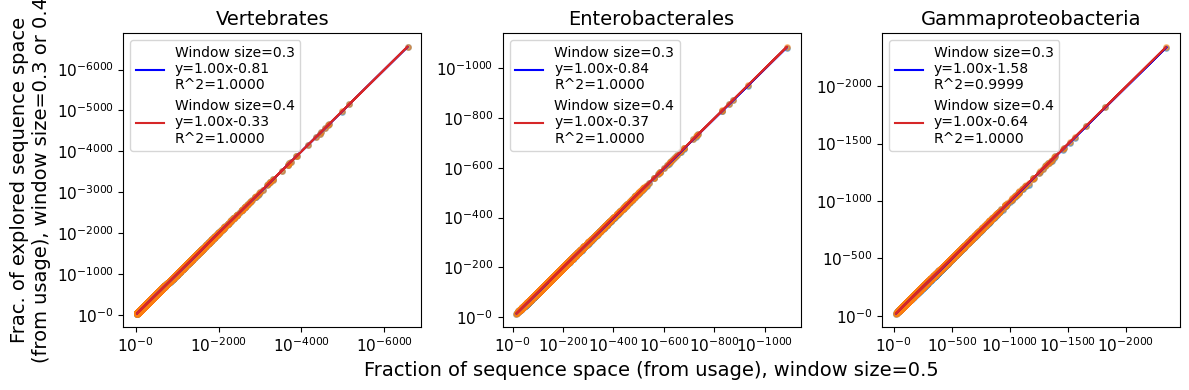

In [47]:
fig, ax=plt.subplots(1,3, figsize=(12,4))
names=['Vertebrates', 'Enterobacterales', 'Gammaproteobacteria']
dfr=[vdfr34, edfr34, gdfr34[~gdfr34['median_alphabet_size_less02gaps'].isna()]]
for i in range(3):
    seqsp.plot_density(dfr[i]['n_seq_diff_usage_log10'], dfr[i]['ws0.3n_seq_diff_usage_log10'], '0.5', '0.3',size=15,
                  ax=ax[i], regcolor='blue', dropna=False,  density=False, legend='Window size=0.3\n', inpdf=False)
    seqsp.plot_density(dfr[i]['n_seq_diff_usage_log10'], dfr[i]['ws0.4n_seq_diff_usage_log10'], '0.5', '0.4', size=15,
                 ax=ax[i], regcolor='tab:red', density=False, dropna=False, legend='Window size=0.4\n', inpdf=False)
    plt.plot()
    ax[i].set_title(names[i], size=14)
    if i!=0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('Frac. of explored sequence space\n(from usage), window size=0.3 or 0.4', size=14)
    if i!=1:
        ax[i].set_xlabel('')
    else:
        ax[i].set_xlabel('Fraction of sequence space (from usage), window size=0.5', size=14)
    ax[i].tick_params(axis='both', which='major', labelsize=11)

#format axes
for axi in ax:
    axi.xaxis.set_major_formatter(FuncFormatter(loglike_formatter))
    axi.yaxis.set_major_formatter(FuncFormatter(loglike_formatter))


plt.tight_layout()


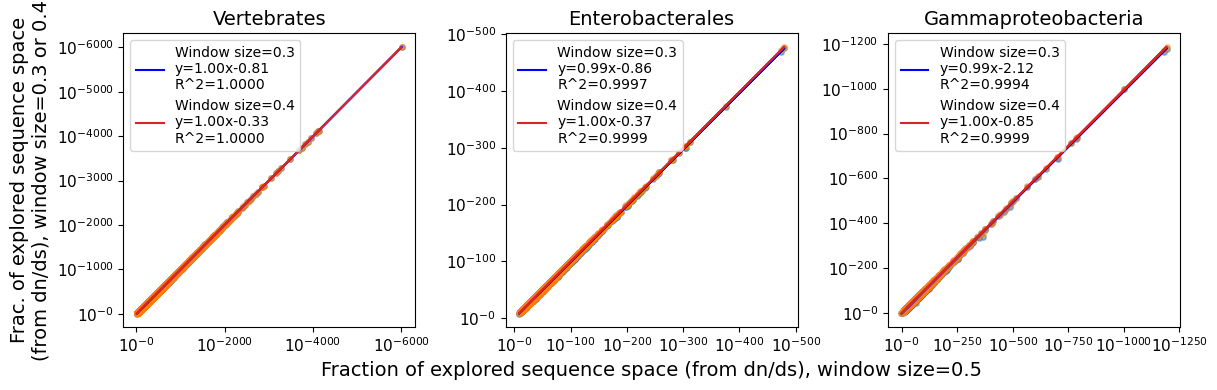

In [48]:
fig, ax=plt.subplots(1,3, figsize=(12,4))
names=['Vertebrates', 'Enterobacterales', 'Gammaproteobacteria']
dfr=[vdfr34, edfr34, gdfr34[~gdfr34['median_alphabet_size_less02gaps'].isna()]]
for i in range(3):
    seqsp.plot_density(dfr[i]['n_seq_diff_dnds_log10'], dfr[i]['ws0.3n_seq_diff_dnds_log10'], '0.5', '0.3',size=15,
                  ax=ax[i], regcolor='blue', dropna=False,  density=False, legend='Window size=0.3\n', inpdf=False)
    seqsp.plot_density(dfr[i]['n_seq_diff_dnds_log10'], dfr[i]['ws0.4n_seq_diff_dnds_log10'], '0.5', '0.4', size=15,
                 ax=ax[i], regcolor='tab:red', density=False, dropna=False, legend='Window size=0.4\n', inpdf=False)
    plt.plot()
    ax[i].set_title(names[i], size=14)
    if i!=0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('Frac. of explored sequence space\n(from dn/ds), window size=0.3 or 0.4', size=14)
    if i!=1:
        ax[i].set_xlabel('')
    else:
        ax[i].set_xlabel('Fraction of explored sequence space (from dn/ds), window size=0.5', size=14)
    ax[i].tick_params(axis='both', which='major', labelsize=11)
    
#format axes
for axi in ax:
    axi.xaxis.set_major_formatter(FuncFormatter(loglike_formatter))
    axi.yaxis.set_major_formatter(FuncFormatter(loglike_formatter))

plt.tight_layout()



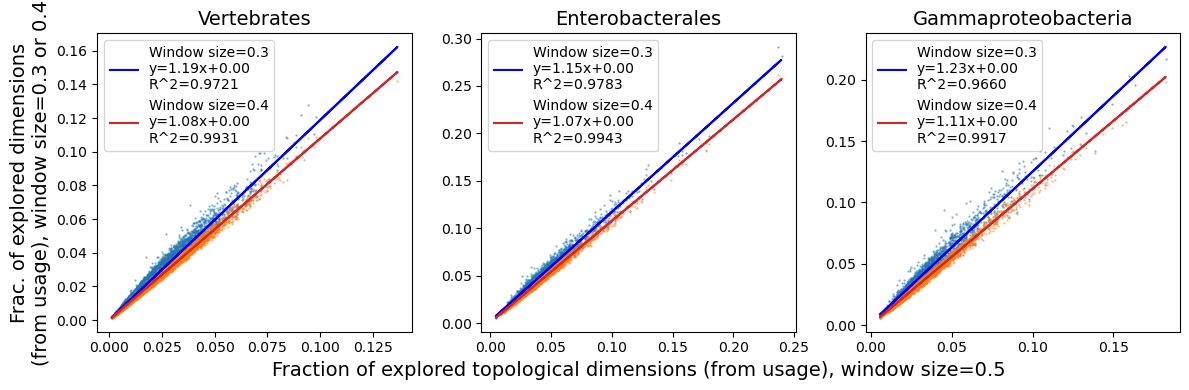

In [19]:
fig, ax=plt.subplots(1,3, figsize=(12,4))
names=['Vertebrates', 'Enterobacterales', 'Gammaproteobacteria']
dfr=[vdfr34, edfr34, gdfr34[~gdfr34['median_alphabet_size_less02gaps'].isna()]]
for i in range(3):
    seqsp.plot_density(dfr[i]['n_seq_from_dim_log20']/dfr[i]['n_seq_bin_expected_from_usage_log20'], dfr[i]['ws0.3n_seq_from_dim_log20']/dfr[i]['n_seq_bin_expected_from_usage_log20'], '0.5', '0.3',
                  ax=ax[i], regcolor='blue', dropna=False,  density=False, legend='Window size=0.3\n', inpdf=False)
    seqsp.plot_density(dfr[i]['n_seq_from_dim_log20']/dfr[i]['n_seq_bin_expected_from_usage_log20'], dfr[i]['ws0.4n_seq_from_dim_log20']/dfr[i]['n_seq_bin_expected_from_usage_log20'], '0.5', '0.4', 
                 ax=ax[i], regcolor='tab:red', density=False, dropna=False, legend='Window size=0.4\n', inpdf=False)
    plt.plot()
    ax[i].set_title(names[i], size=14)
    if i!=0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('Frac. of explored dimensions\n(from usage), window size=0.3 or 0.4', size=14)
    if i!=1:
        ax[i].set_xlabel('')
    else:
        ax[i].set_xlabel('Fraction of explored topological dimensions (from usage), window size=0.5', size=14)
plt.tight_layout()


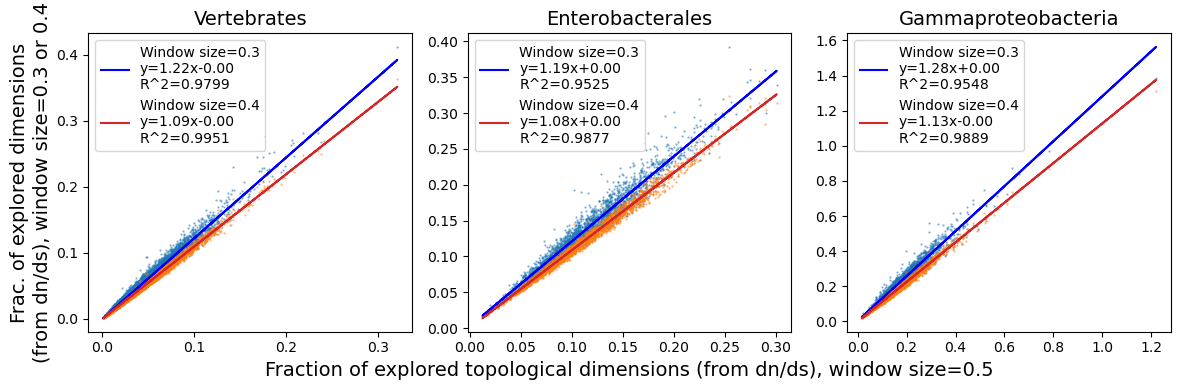

In [20]:
fig, ax=plt.subplots(1,3, figsize=(12,4))
names=['Vertebrates', 'Enterobacterales', 'Gammaproteobacteria']
dfr=[vdfr34, edfr34, gdfr34[~gdfr34['median_alphabet_size_less02gaps'].isna()]]
for i in range(3):
    seqsp.plot_density(dfr[i]['n_seq_from_dim_log20']/dfr[i]['n_seq_bin_expected_from_dn/ds_log20'], dfr[i]['ws0.3n_seq_from_dim_log20']/dfr[i]['n_seq_bin_expected_from_dn/ds_log20'], '0.5', '0.3',
                  ax=ax[i], regcolor='blue', dropna=False,  density=False, legend='Window size=0.3\n', inpdf=False)
    seqsp.plot_density(dfr[i]['n_seq_from_dim_log20']/dfr[i]['n_seq_bin_expected_from_dn/ds_log20'], dfr[i]['ws0.4n_seq_from_dim_log20']/dfr[i]['n_seq_bin_expected_from_dn/ds_log20'], '0.5', '0.4', 
                 ax=ax[i], regcolor='tab:red', density=False, dropna=False, legend='Window size=0.4\n', inpdf=False)
    plt.plot()
    ax[i].set_title(names[i], size=14)
    if i!=0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('Frac. of explored dimensions\n(from dn/ds), window size=0.3 or 0.4', size=14)
    if i!=1:
        ax[i].set_xlabel('')
    else:
        ax[i].set_xlabel('Fraction of explored topological dimensions (from dn/ds), window size=0.5', size=14)
plt.tight_layout()


# Compare dim from pairwise and multiple alignments

In [21]:
# Load dimensionality estimated using the regression range determined by each distance matrix 
vdfr=pd.read_csv(allsumpath+'vertebrates_summary.csv')
edfr=pd.read_csv(allsumpath+'enterobacterales_summary.csv')
gdfr=pd.read_csv(allsumpath+'gammaproteobacteria_summary.csv')
sdfr=pd.read_csv(allsumpath+'simulated_summary.csv')

In [ ]:
#get random 5% of OGs [NOT REQUIRED TO OBTAIN PLOTS]
for i , name in zip([vdfr, edfr, gdfr[~gdfr['median_alphabet_size_less02gaps'].isna()]], ['vert', 'entero', 'gamma']):
    ids=np.random.choice(list(i['OG_id']), size=int(0.05*len(i)), replace=False)
    pd.DataFrame(ids).to_csv(f'../data/dim_diff_reg_range/random_0.05_og_ids_{name}_for_pairali.list', index=False, header=False)

In [22]:
#add range_from_data dim with win_size 0.3 and 0.4 for these 5% of OGs
l=['vert_pairali_kcoefs_max_k_range_from_data_non_log_0.5_20.coefnr', 
   'entero_pairali_kcoefs_max_k_range_from_data_non_log_0.5_20.coefnr', 
   'gamma_pairali_kcoefs_max_k_range_from_data_non_log_0.5_20.coefnr']
dfs_pair=[]
for ind, i in enumerate(l):
    df=pd.read_csv(allsumpath+'dim_diff_reg_range/'+i, sep=',')
    coln=['range_start_data_range_','range_end_data_range_','max_k_data_range_','max_k_R^2_data_range_','max_CI_data_range_']

    df.columns=['OG_id']+[i+'pairali' for i in coln]
    dfs_pair.append(df)

vdfr_p=vdfr.merge(dfs_pair[0], on='OG_id')
edfr_p=edfr.merge(dfs_pair[1], on='OG_id')
gdfr_p=gdfr.merge(dfs_pair[2], on='OG_id')

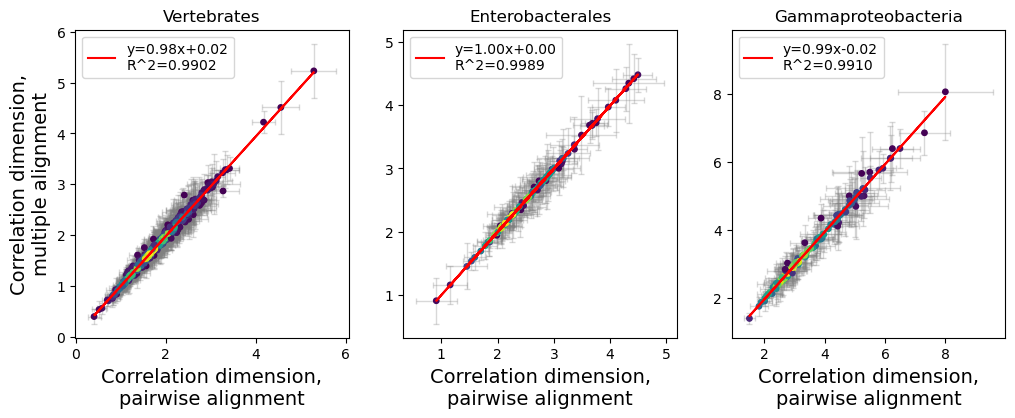

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
names = ['Vertebrates', 'Enterobacterales', 'Gammaproteobacteria']
dfr = [vdfr_p, edfr_p, gdfr_p]

for i in range(3):
    df = dfr[i]

    # main scatter / density plot

    # add confidence intervals
    ax[i].errorbar(
        x=df['max_k_data_range_pairali'],
        y=df['dim_ur'],
        xerr=df['max_CI_data_range_pairali'],
        yerr=df['dim_CI_ur'],
        fmt='none',          # no markers, just error bars
        ecolor='gray',       # color of error bars
        elinewidth=1,        # thickness
        alpha=0.3,           # transparency
        capsize=2 ,           # small caps at ends
        zorder=1
    )

    seqsp.plot_density(df, '', 'max_k_data_range_pairali', 'dim_ur', dropna=True, ax=ax[i], size=15)

    ax[i].set_title(names[i])
    if i != 0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('Correlation dimension,\nmultiple alignment', size=14)
    ax[i].set_xlabel('Correlation dimension,\npairwise alignment', size=14)

    